In [1]:
import pandas as pd
import numpy as np
import scorecardpy as sc
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('data/train/accounts_data_train.json') as file:
    acc_json = json.load(file)

with open('data/train/enquiry_data_train.json') as file2:
    enq_json = json.load(file2)

In [3]:
flattened_acc_data = [item for sublist in acc_json for item in sublist]
flattened_enq_data = [item for sublist in enq_json for item in sublist]

In [4]:
df_acc = pd.DataFrame(flattened_acc_data)
df_enq = pd.DataFrame(flattened_enq_data)

In [5]:
train_flag = pd.read_csv('data/train/train_flag.csv')

## EDA

In [6]:
print(df_acc.head())
print(df_enq.head())

       credit_type  loan_amount  amount_overdue   open_date closed_date  \
0  Consumer credit   272745.000             0.0  2018-09-22  2020-02-22   
1  Consumer credit     4500.000             0.0  2018-03-08  2019-07-25   
2      Credit card    80996.445             0.0  2020-06-29         NaN   
3  Consumer credit    43771.500             0.0  2020-06-09  2020-09-09   
4      Credit card    10480.500             0.0  2014-09-10         NaN   

                                 payment_hist_string          uid  
0  0000000000000000000000100000000000000000000000...  AAA09044550  
1   000000000000000014044000000000000000000000000000  AAA09044550  
2                                 000000000000000000  AAA10545297  
3                                          000000000  AAA14112888  
4  0000000000000000000000000000000000000000000000...  AAA20326915  
                enquiry_type  enquiry_amt enquiry_date          uid
0           Interbank credit       168839   2020-11-08  AAA08065248
1    

In [7]:
print(df_acc.describe())
print(df_enq.describe())

        loan_amount  amount_overdue
count  1.245307e+06    1.245310e+06
mean   3.523541e+05    4.202288e+01
std    1.109812e+06    6.668687e+03
min    0.000000e+00    0.000000e+00
25%    5.114700e+04    0.000000e+00
50%    1.246590e+05    0.000000e+00
75%    3.087000e+05    0.000000e+00
max    3.960000e+08    3.756681e+06
        enquiry_amt
count  1.909926e+06
mean   1.160423e+05
std    8.207031e+04
min    1.007000e+03
25%    5.600000e+04
50%    1.080000e+05
75%    1.590000e+05
max    4.999950e+05


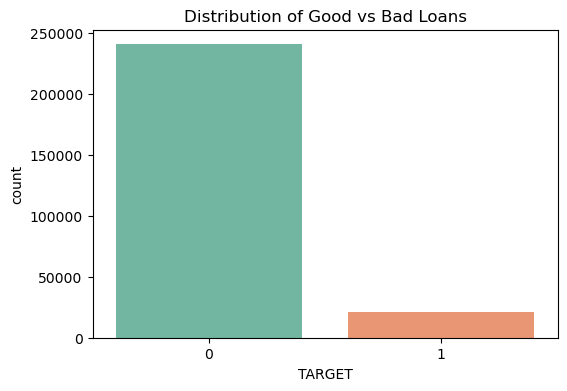

In [16]:
# Check the distribution of loan status
plt.figure(figsize=(6,4))
sns.countplot(x='TARGET', data=train_flag, palette="Set2")
plt.title("Distribution of Good vs Bad Loans")
plt.show()

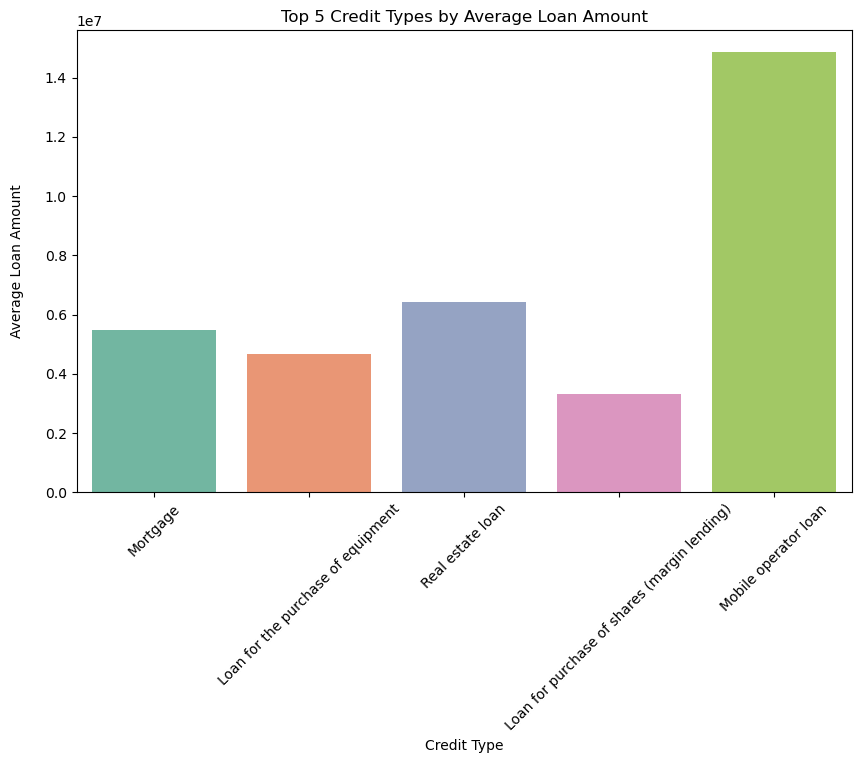

In [21]:
# Create the bar plot with adjusted y-axis label position
plt.figure(figsize=(10,6))
sns.barplot(data=df_top_5, x='credit_type', y='loan_amount', estimator='mean', ci=None, palette="Set2")
plt.title("Top 5 Credit Types by Average Loan Amount")
plt.xlabel("Credit Type")
plt.ylabel("Average Loan Amount", labelpad=15)  # Adjust labelpad for y-axis label alignment
plt.xticks(rotation=45)
plt.show()

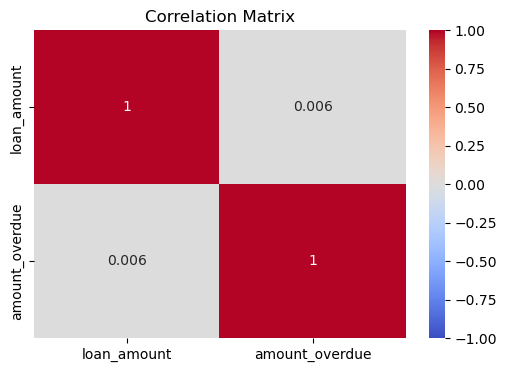

In [19]:
# Correlation Analysis
correlation_matrix = df_acc[['loan_amount', 'amount_overdue']].corr()
plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

## Feature creation

In [8]:
# Define mapping for secured and unsecured loans
loan_security_mapping = {
    'Consumer credit': 'Unsecured',
    'Credit card': 'Unsecured',
    'Car loan': 'Secured',
    'Mortgage': 'Secured',
    'Microloan': 'Unsecured',
    'Loan for business development': 'Secured',
    'Another type of loan': 'Variable',
    'Unknown type of loan': 'Variable',
    'Loan for working capital replenishment': 'Secured',
    'Real estate loan': 'Secured',
    'Cash loan (non-earmarked)': 'Unsecured',
    'Loan for the purchase of equipment': 'Secured',
    'Loan for purchase of shares (margin lending)': 'Secured',
    'Interbank credit': 'Variable',
    'Mobile operator loan': 'Unsecured'
}

In [9]:
# Map the loan types to secured/unsecured categories
df_acc['security_type'] = df_acc['credit_type'].map(loan_security_mapping)

In [29]:
# Create the crosstab to count each loan type per uid
loan_counts = pd.crosstab(df_acc['uid'], df_acc['security_type'])

# Rename columns to the specified format
loan_counts = loan_counts.rename(columns={
    'secured': 'no_of_secured_loans', 
    'unsecured': 'no_of_unsecured_loans', 
    'variable': 'no_of_variable'
}).reset_index()

In [10]:
df_acc_feat = df_acc.groupby('uid')['credit_type'].nunique().reset_index(name='distinct_credit_type')

In [11]:
df_count = df_acc.groupby('uid').size().reset_index(name='credit_type_count')

In [12]:
df_acc_feat = pd.merge(df_acc_feat, df_count, on='uid', how='inner')

In [13]:
df_acc['credit_type_cleaned'] = df_acc['credit_type'].str.lower().str.replace(' ', '_')

In [17]:
df_acc_feat = pd.merge(df_acc_feat, df_count, on='uid', how='inner')

In [30]:
df_acc_feat = pd.merge(df_acc_feat, loan_counts, on='uid', how='inner')

## Loan amount features w.r.t credit_type

In [18]:
agg_df = df_acc.groupby(['uid', 'credit_type_cleaned'])['loan_amount'].agg(['min', 'max', 'mean', 'sum'])
agg_df = agg_df.unstack(fill_value='missing')

agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
agg_df = agg_df.reset_index()

In [19]:
agg_df

,uid,min_another_type_of_loan,min_car_loan,min_cash_loan_(non-earmarked),min_consumer_credit,min_credit_card,min_interbank_credit,min_loan_for_business_development,min_loan_for_purchase_of_shares_(margin_lending),min_loan_for_the_purchase_of_equipment,...,sum_interbank_credit,sum_loan_for_business_development,sum_loan_for_purchase_of_shares_(margin_lending),sum_loan_for_the_purchase_of_equipment,sum_loan_for_working_capital_replenishment,sum_microloan,sum_mobile_operator_loan,sum_mortgage,sum_real_estate_loan,sum_unknown_type_of_loan
0,AAA09044550,missing,missing,missing,4500.0,missing,missing,missing,missing,missing,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
1,AAA10545297,missing,missing,missing,missing,80996.445,missing,missing,missing,missing,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
2,AAA14112888,missing,missing,missing,43771.5,missing,missing,missing,missing,missing,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
3,AAA20326915,missing,missing,missing,46620.0,0.0,missing,missing,missing,missing,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
4,AAA31604840,missing,missing,missing,41845.5,90000.0,missing,missing,missing,missing,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223913,ZZZ74526004,missing,missing,missing,17505.0,missing,missing,missing,missing,missing,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
223914,ZZZ78449185,missing,missing,missing,40455.0,missing,missing,missing,missing,missing,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
223915,ZZZ79008454,missing,missing,missing,170914.5,missing,missing,missing,missing,missing,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
223916,ZZZ81253108,missing,2529720.0,missing,234000.0,121500.0,missing,missing,missing,missing,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing


In [20]:
df_acc_feat = pd.merge(df_acc_feat, agg_df, on='uid', how='inner')

## open date

In [22]:
df_acc['open_date'] = pd.to_datetime(df_acc['open_date'])
df_acc['closed_date'] = pd.to_datetime(df_acc['closed_date'])

In [23]:
df_acc_date = df_acc.sort_values(by=['uid','open_date'])[['uid','open_date']]

In [24]:
# Calculate the difference in days between consecutive dates within each 'uid'
df_acc_date['date_diff'] = df_acc_date.groupby('uid')['open_date'].diff().dt.days

# Calculate the min, max, mean, and sum of 'date_diff' for each 'uid'
df_loan_dates = df_acc_date.groupby('uid')['date_diff'].agg(['min', 'max', 'mean', 'sum']).add_prefix('date_diff_').reset_index()

In [25]:
df_loan_dates = df_loan_dates.fillna(0)

In [26]:
df_loan_dates

,uid,date_diff_min,date_diff_max,date_diff_mean,date_diff_sum
0,AAA09044550,198.0,198.0,198.000000,198.0
1,AAA10545297,0.0,0.0,0.000000,0.0
2,AAA14112888,0.0,0.0,0.000000,0.0
3,AAA20326915,0.0,802.0,302.571429,2118.0
4,AAA31604840,24.0,675.0,333.250000,1333.0
...,...,...,...,...,...
223913,ZZZ74526004,242.0,1681.0,961.500000,1923.0
223914,ZZZ78449185,27.0,396.0,198.833333,1193.0
223915,ZZZ79008454,344.0,771.0,557.500000,1115.0
223916,ZZZ81253108,4.0,392.0,218.000000,654.0


In [27]:
df_acc_feat = pd.merge(df_acc_feat, df_loan_dates, on='uid', how='inner')

## ongoing loans

In [31]:
# Count null values in 'closed_date' for each 'uid'
ongoing_loans_count = df_acc['closed_date'].isna().groupby(df_acc['uid']).sum().reset_index()
ongoing_loans_count.columns = ['uid', 'no_of_ongoing_loans']

In [32]:
df_acc_feat = pd.merge(df_acc_feat, ongoing_loans_count, on='uid', how='inner')

In [33]:
# Count null values in 'closed_date' for each ('uid', 'credit_type') combination
ongoing_loans_type = df_acc['closed_date'].isna().groupby([df_acc['uid'], df_acc['credit_type_cleaned']]).sum().reset_index()
ongoing_loans_type.columns = ['uid', 'credit_type_cleaned', 'no_of_ongoing_loans']
ongoing_loans_type = ongoing_loans_type.pivot(index='uid', columns='credit_type_cleaned', values='no_of_ongoing_loans').fillna(0)
ongoing_loans_type.columns = [f"no_of_ongoing_{col.lower().replace(' ', '_')}" for col in ongoing_loans_type.columns]

# Reset index to make 'uid' a column again
ongoing_loans_type = ongoing_loans_type.reset_index()

In [34]:
ongoing_loans_type

,uid,no_of_ongoing_another_type_of_loan,no_of_ongoing_car_loan,no_of_ongoing_cash_loan_(non-earmarked),no_of_ongoing_consumer_credit,no_of_ongoing_credit_card,no_of_ongoing_interbank_credit,no_of_ongoing_loan_for_business_development,no_of_ongoing_loan_for_purchase_of_shares_(margin_lending),no_of_ongoing_loan_for_the_purchase_of_equipment,no_of_ongoing_loan_for_working_capital_replenishment,no_of_ongoing_microloan,no_of_ongoing_mobile_operator_loan,no_of_ongoing_mortgage,no_of_ongoing_real_estate_loan,no_of_ongoing_unknown_type_of_loan
0,AAA09044550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AAA10545297,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AAA14112888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AAA20326915,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AAA31604840,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223913,ZZZ74526004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223914,ZZZ78449185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223915,ZZZ79008454,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223916,ZZZ81253108,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
df_acc_feat = pd.merge(df_acc_feat, ongoing_loans_type, on='uid', how='inner')

## Enquiry features

In [36]:
df_enq['enquiry_type_cleaned'] = df_enq['enquiry_type'].str.lower().str.replace(' ', '_') + '' + '_enquiry'

In [37]:
agg_df_enq = df_enq.groupby(['uid', 'enquiry_type_cleaned'])['enquiry_amt'].agg(['min', 'max', 'mean', 'sum'])
agg_df_enq = agg_df_enq.unstack(fill_value=0)

agg_df_enq.columns = ['_'.join(col).strip() for col in agg_df_enq.columns.values]
agg_df_enq = agg_df_enq.reset_index()

In [38]:
agg_df_enq

,uid,min_another_type_of_loan_enquiry,min_car_loan_enquiry,min_cash_loan_(non-earmarked)_enquiry,min_cash_loans_enquiry,min_consumer_credit_enquiry,min_credit_card_enquiry,min_interbank_credit_enquiry,min_loan_for_business_development_enquiry,min_loan_for_purchase_of_shares_(margin_lending)_enquiry,...,sum_loan_for_business_development_enquiry,sum_loan_for_purchase_of_shares_(margin_lending)_enquiry,sum_loan_for_the_purchase_of_equipment_enquiry,sum_loan_for_working_capital_replenishment_enquiry,sum_microloan_enquiry,sum_mobile_operator_loan_enquiry,sum_mortgage_enquiry,sum_real_estate_loan_enquiry,sum_revolving_loans_enquiry,sum_unknown_type_of_loan_enquiry
0,AAA08065248,0,0,227459,0,0,0,127618,0,161562,...,0,477153,0,0,0,304474,44841,0,533807,0
1,AAA09044550,24000,5000,139000,85000,111000,149000,86000,0,0,...,0,0,87000,0,50000,102000,32000,65000,94000,98000
2,AAA10545297,126000,0,9000,65000,18000,94000,24000,0,58000,...,0,58000,0,0,0,0,0,0,99000,134000
3,AAA14112888,185000,0,95000,94000,62000,0,112000,0,39000,...,0,91000,216000,260000,0,249000,0,0,0,17000
4,AAA20326915,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,66000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261378,ZZZ74526004,0,0,0,33000,108000,0,0,121000,0,...,121000,0,89000,184000,0,0,257000,106000,0,0
261379,ZZZ78449185,0,0,0,0,0,413394,0,0,497141,...,0,497141,384000,0,0,40274,0,821152,0,0
261380,ZZZ79008454,0,0,0,0,0,0,0,0,0,...,0,0,0,0,28000,0,0,0,0,0
261381,ZZZ81253108,55000,61000,0,30000,0,0,183000,30000,76000,...,446000,266000,109000,191000,58000,373000,0,298000,120000,94000


In [39]:
df_enq_feat = df_enq.groupby('uid')['enquiry_type'].nunique().reset_index(name='distinct_enquiry_type')

In [172]:
df_enq_feat

,uid,distinct_enquiry_type
0,AAA08065248,6
1,AAA09044550,14
2,AAA10545297,9
3,AAA14112888,10
4,AAA20326915,1
...,...,...
261378,ZZZ74526004,7
261379,ZZZ78449185,5
261380,ZZZ79008454,1
261381,ZZZ81253108,13


In [40]:
df_enq_count = df_enq.groupby('uid').size().reset_index(name='enquiry_count')

In [41]:
df_enq_feat = pd.merge(df_enq_feat, df_enq_count, on='uid', how='inner')

In [42]:
df_enq_feat = pd.merge(df_enq_feat, agg_df_enq, on='uid', how='inner')

## Overdue Amount

In [43]:
# Group by 'uid' and 'credit_type_cleaned' and calculate min, max, mean, and sum for 'amount_overdue'
agg_df_overdue = df_acc.groupby(['uid', 'credit_type_cleaned'])['amount_overdue'].agg(['min', 'max', 'mean', 'sum'])
agg_df_overdue = agg_df_overdue.unstack(fill_value=0)
agg_df_overdue.columns = [f"{func}_amount_overdue_{credit_type}" for func, credit_type in agg_df_overdue.columns]
agg_df_overdue = agg_df_overdue.reset_index()

## Payment history 

In [44]:
df_pay = df_acc[['uid','payment_hist_string']]

In [45]:
# Function to split payment history into list of integers
def split_payment_history(s):
    if not s or len(s) % 3 != 0:
        return []  
    return [int(s[i:i+3]) for i in range(0, len(s), 3)]

df_pay['payment_history'] = df_pay['payment_hist_string'].apply(split_payment_history)

df_pay['total_overdue'] = df_pay['payment_history'].apply(lambda x: sum(x) if x else 0)
df_pay['avg_overdue'] = df_pay['payment_history'].apply(lambda x: np.mean(x) if x else 0)
df_pay['max_overdue'] = df_pay['payment_history'].apply(lambda x: max(x) if x else 0)
df_pay['min_overdue'] = df_pay['payment_history'].apply(lambda x: min(x) if x else 0)
df_pay['std_overdue'] = df_pay['payment_history'].apply(lambda x: np.std(x) if x else 0)
df_pay['num_payments'] = df_pay['payment_history'].apply(len)

# Aggregate these statistics at the 'uid' level
df_pay_stats = df_pay.groupby('uid').agg({
    'total_overdue': 'sum',  
    'avg_overdue': 'mean',  
    'max_overdue': 'max',   
    'min_overdue': 'min',    
    'std_overdue': 'mean',  
    'num_payments': 'sum'  
}).reset_index()


df_pay_stats.columns = [
    'uid', 
    'total_overdue', 
    'avg_overdue', 
    'max_overdue', 
    'min_overdue', 
    'std_overdue', 
    'num_payments'
]


In [46]:
# Most recent overdue days for each row
df_pay['recent_overdue'] = df_pay['payment_history'].apply(lambda x: x[-1] if len(x) > 0 else 0)

# Trend Indicator: Simple trend based on first and last overdue days for each row
def calculate_trend(history):
    if len(history) < 2:
        return 0  # No trend
    if history[-1] > history[0]:
        return 1  # Increasing trend
    elif history[-1] < history[0]:
        return -1  # Decreasing trend
    else:
        return 0  # Stable

df_pay['overdue_trend'] = df_pay['payment_history'].apply(calculate_trend)

# Number of consecutive on-time payments from the most recent month backwards for each row
def consecutive_on_time(history):
    count = 0
    for day in reversed(history):
        if day == 0:
            count += 1
        else:
            break
    return count

df_pay['consecutive_on_time'] = df_pay['payment_history'].apply(consecutive_on_time)

# Aggregating these features at the uid level
df_pay_trend = df_pay.groupby('uid').agg({
    'recent_overdue': 'max',           # Most recent overdue across all entries for uid
    'overdue_trend': 'max',            # Aggregate trend direction, taking max for simplicity
    'consecutive_on_time': 'max'       # Max consecutive on-time payments across all entries
}).reset_index()

# Rename columns for clarity
df_pay_trend.columns = [
    'uid', 
    'max_recent_overdue', 
    'overall_overdue_trend', 
    'max_consecutive_on_time'
]


In [47]:
# Count of overdue days in the last 3 months for each row
df_pay['late_last_3'] = df_pay['payment_history'].apply(lambda x: sum(1 for day in x[-3:] if day > 0))

# Indicator if any month had overdue days > 10 for each row
df_pay['any_overdue_gt_10'] = df_pay['payment_history'].apply(lambda x: 1 if any(day > 10 for day in x) else 0)

df_last_3 = df_pay.groupby('uid').agg({
    'late_last_3': 'sum',             
    'any_overdue_gt_10': 'max'         
}).reset_index()

# Rename columns for clarity
df_last_3.columns = [
    'uid', 
    'total_late_last_3', 
    'any_overdue_gt_10'
]

In [48]:
# Function to count increasing and decreasing sequences
def count_trends(history):
    increasing = 0
    decreasing = 0
    for i in range(1, len(history)):
        if history[i] > history[i - 1]:
            increasing += 1
        elif history[i] < history[i - 1]:
            decreasing += 1
    return increasing, decreasing

# Calculate the increasing and decreasing sequences for each row
df_pay[['num_increasing_seq', 'num_decreasing_seq']] = df_pay['payment_history'].apply(
    lambda x: pd.Series(count_trends(x))
)

df_pay_seq = df_pay.groupby('uid').agg({
    'num_increasing_seq': 'sum',     
    'num_decreasing_seq': 'sum'       
}).reset_index()

df_pay_seq.columns = [
    'uid', 
    'total_increasing_seq', 
    'total_decreasing_seq'
]


In [49]:
# Merge payment hist dataframes
df_payment_hist = pd.merge(df_pay_stats, df_pay_trend, on='uid', how='inner')
df_payment_hist = pd.merge(df_payment_hist, df_last_3, on='uid', how='inner')
df_payment_hist = pd.merge(df_payment_hist, df_pay_seq, on='uid', how='inner')

In [58]:
df_all = pd.merge(df_acc_feat,df_payment_hist, on='uid', how='inner')
df_all = pd.merge(df_all,df_enq_feat, on='uid', how='inner')

## Additional features

In [63]:
df_features = df_acc.groupby('uid').agg(
    # Duration-based Features
    avg_loan_duration=('closed_date', lambda x: np.mean((x - df_acc.loc[x.index, 'open_date']).dt.days)),
    total_loan_duration=('closed_date', lambda x: np.sum((x - df_acc.loc[x.index, 'open_date']).dt.days)),
    longest_loan_duration=('closed_date', lambda x: np.max((x - df_acc.loc[x.index, 'open_date']).dt.days)),
    shortest_loan_duration=('closed_date', lambda x: np.min((x - df_acc.loc[x.index, 'open_date']).dt.days)),
    
    loans_still_open=('closed_date', lambda x: x.isna().sum()),
    proportion_open_loans=('closed_date', lambda x: x.isna().mean())
)

# Additional feature: days since last loan
df_features['last_loan_date'] = df_acc.groupby('uid')['open_date'].max()
df_features['days_since_last_loan'] = (pd.to_datetime('today') - df_features['last_loan_date']).dt.days
df_features.drop(columns='last_loan_date', inplace=True)



In [ ]:
df_all = pd.merge(df_all,df_features, on='uid', how='inner')

In [ ]:
df_all.to_csv('final_features.csv', index=False)